In [11]:
#Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [12]:
warnings.filterwarnings('ignore')

In [13]:
#Function to read parquet file
def read_parquet_file(file_path):
    df = pd.read_parquet(file_path)
    return df

In [14]:
#Importing document
file_path = '/Users/salmahoumane/Downloads/24-07-31_2w_all_events.parquet'
df = read_parquet_file(file_path)

In [15]:
# Print the column names
print("Column names:")
print(df.columns)

Column names:
Index(['UNITNO', 'SCAN_DATETIME', 'EVENT_CODE', 'EVENT_REASON', 'WEIGHT',
       'VOLUME', 'STACKABLE', 'SMALL', 'HAZARDOUS', 'BELT',
       'DESTINATION_ZIPCODE', 'EVENT_TYPE', 'RAW_DESTINATION_DEPOT_ID',
       'RAW_SCAN_DEPOT_ID', 'DESTINATION_DEPOT_ID', 'SCAN_DEPOT_ID',
       'DESTINATION_SCAN_DATETIME', 'FIRST_SCAN_DATETIME', 'NEXT_DEPOT_ID',
       'NEXT_SCAN_DATETIME', 'PREVIOUS_DEPOT_ID', 'PREVIOUS_SCAN_DATETIME'],
      dtype='object')


In [16]:
#Concatenating event code and event reason
df['EVENT_CONCAT'] = df['EVENT_CODE'].astype(str) + '-' + df['EVENT_REASON'].astype(str)

In [17]:
# Convert datetime columns to datetime type
df['DESTINATION_SCAN_DATETIME'] = pd.to_datetime(df['DESTINATION_SCAN_DATETIME'])
df['FIRST_SCAN_DATETIME'] = pd.to_datetime(df['FIRST_SCAN_DATETIME'])
# Add a new column for the week of the year
df['SCAN_WEEK_OF_YEAR'] = df['SCAN_DATETIME'].dt.strftime("%V").astype(str).astype(int)
# Add a new column for the day of the week
df['SCAN_DAY_OF_WEEK'] = df['SCAN_DATETIME'].dt.dayofweek
# Add a new column to indicate if the scan happened on a Friday
df['IS_FRIDAY'] = df['SCAN_DATETIME'].dt.dayofweek == 4
# Add a new column for the hour of the scan
df['SCAN_HOUR'] = df['SCAN_DATETIME'].dt.hour
# Add a new column for the minute of the scan
df['SCAN_MINUTE'] = df['SCAN_DATETIME'].dt.minute
# Add a new column to indicate if the scan happened before 10 AM
df['SCAN_BEFORE_10'] = df['SCAN_HOUR'] < 10

In [18]:
# Define a function to calculate the cutoff time
def next_10am_after(scan_time, IS_FRIDAY, scan_hour):
    if scan_hour < 10:
        # If the scan is before 10 AM, set cutoff to the next day's 10 AM
        next_day = scan_time + pd.Timedelta(days=1)
        cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    else:
        if IS_FRIDAY:
            # If the scan is on Friday and after 10 AM, set cutoff to Monday 10 AM
            next_monday = scan_time + pd.Timedelta(days=(7 - scan_time.weekday())) # 7 - weekday() gives the days to Monday
            cutoff_time = next_monday.replace(hour=10, minute=0, second=0, microsecond=0)
        else:
            # Otherwise, set cutoff to the next day's 10 AM
            next_day = scan_time + pd.Timedelta(days=1)
            cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    return cutoff_time

In [22]:
# Drop duplicate rows based on 'UNITNO' and 'EVENT_REASON', keeping only the first occurrence
df_unique = df.drop_duplicates(subset=['UNITNO', 'EVENT_REASON'], keep='first')
# Apply the function to calculate the cutoff time for each row
df_unique['cutoff_time'] = df_unique.apply(
    lambda row: next_10am_after(row['FIRST_SCAN_DATETIME'], row['IS_FRIDAY'], row['SCAN_HOUR']),
    axis=1
)
# Create the `on_time` variable based on the new criteria
df_unique['ON_TIME'] = df_unique['DESTINATION_SCAN_DATETIME'] <= df_unique['cutoff_time']

In [23]:
#Filter data for inbound records
inbound_df = df_unique[df_unique['EVENT_CODE'] == 2]

In [24]:
# Drop duplicate rows based on 'UNITNO' keeping only the first occurrence
inbound_df_filtered = inbound_df.drop_duplicates(subset=['UNITNO'], keep='first')

In [25]:
# Print the column names
print("Column names:")
print(inbound_df_filtered.columns)

Column names:
Index(['UNITNO', 'SCAN_DATETIME', 'EVENT_CODE', 'EVENT_REASON', 'WEIGHT',
       'VOLUME', 'STACKABLE', 'SMALL', 'HAZARDOUS', 'BELT',
       'DESTINATION_ZIPCODE', 'EVENT_TYPE', 'RAW_DESTINATION_DEPOT_ID',
       'RAW_SCAN_DEPOT_ID', 'DESTINATION_DEPOT_ID', 'SCAN_DEPOT_ID',
       'DESTINATION_SCAN_DATETIME', 'FIRST_SCAN_DATETIME', 'NEXT_DEPOT_ID',
       'NEXT_SCAN_DATETIME', 'PREVIOUS_DEPOT_ID', 'PREVIOUS_SCAN_DATETIME',
       'EVENT_CONCAT', 'SCAN_WEEK_OF_YEAR', 'SCAN_DAY_OF_WEEK', 'IS_FRIDAY',
       'SCAN_HOUR', 'SCAN_MINUTE', 'SCAN_BEFORE_10', 'cutoff_time', 'ON_TIME'],
      dtype='object')


# Calculate the KPI for depot_load

## Composite Score represents Depot load

In [16]:
# Assuming that depot_metrics is a DataFrame with the required columns
depot_metrics = inbound_df_filtered.groupby('DESTINATION_DEPOT_ID').agg({
    'UNITNO': 'count',  # Total number of inbounds
    'WEIGHT': ['sum', 'mean'],  # Total and average weight
    'VOLUME': ['sum', 'mean']  # Total and average volume
}).reset_index()

In [17]:
# Renaming columns for clarity
depot_metrics.columns = [
    'DESTINATION_DEPOT_ID', 'total_inbounds', 'total_weight', 'average_weight', 'total_volume', 'average_volume'
]

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

In [21]:
# Normalize the KPIs
normalized_kpis = scaler.fit_transform(depot_metrics[['total_inbounds', 'total_weight', 'total_volume', 'average_weight', 'average_volume']])
normalized_df = pd.DataFrame(normalized_kpis, columns=['total_inbounds', 'total_weight', 'total_volume', 'average_weight', 'average_volume'])

In [23]:
# Assign weights and calculate the composite score
weights = {
    'total_inbounds': 0.2,
    'total_weight': 0.3,
    'total_volume': 0.3,
    'average_weight': 0.1,
    'average_volume': 0.1
}

In [25]:
depot_metrics['composite_score'] = (
    normalized_df['total_inbounds'] * weights['total_inbounds'] +
    normalized_df['total_weight'] * weights['total_weight'] +
    normalized_df['total_volume'] * weights['total_volume'] +
    normalized_df['average_weight'] * weights['average_weight'] +
    normalized_df['average_volume'] * weights['average_volume']
)

In [27]:
# Print the resulting DataFrame with composite scores
print(depot_metrics)

    DESTINATION_DEPOT_ID  total_inbounds  total_weight  average_weight  \
0                    100           22132     130276.61        5.886346   
1                    110           13950      90925.23        6.517938   
2                    120           16113     111833.48        6.940575   
3                    130           15751     112997.16        7.173967   
4                    140            8126      65756.45        8.092106   
..                   ...             ...           ...             ...   
63                   850           16520      92440.59        5.595677   
64                   860           12823      83851.43        6.539143   
65                   870           17150      96674.83        5.637016   
66                   880           10763      68300.67        6.345877   
67                   890           14069      80658.08        5.733036   

    total_volume  average_volume  composite_score  
0       73982.47       10.104134         0.429883  
1      

## Optimization of weights: 2 methods 

### Method 1: Correlation Analysis

#### Less computational heavy than Grid Search
The idea is to adjust weights to maximize the correlation between the composite score and the target variable (in this case on_time).
#### BUT
We use Pearson's correlation which is a standard correlation measures that assumes a linear relationship between the variables. If the relationship is nonlinear, the correlation may not fully capture the dependency.

In [37]:
# Define a function to calculate correlation for given weights
def calculate_correlation(weights):
    depot_metrics['composite_score'] = calculate_composite_score(weights)
    correlation, _ = pearsonr(depot_metrics['composite_score'], depot_metrics['on_time_rate'])
    return correlation

In [41]:
# Define a function to calculate the composite score given a set of weights
def calculate_composite_score(weights):
    scores = (normalized_df['total_inbounds'] * weights[0] +
              normalized_df['total_weight'] * weights[1] +
              normalized_df['total_volume'] * weights[2] +
              normalized_df['average_weight'] * weights[3] +
              normalized_df['average_volume'] * weights[4])
    return scores


In [45]:
# On_time_rate is a column in depot_metrics that we want to predict
depot_metrics['on_time_rate'] = inbound_df_filtered.groupby('DESTINATION_DEPOT_ID')['ON_TIME'].mean().values * 100

In [86]:
import itertools

In [88]:
# Define the steps and range for each weight component
step = 0.1
components = 5  # Number of KPIs

In [104]:
# Generate all possible combinations with the given step size
weights_combinations = []
for comb in itertools.product(np.arange(0, 1 + step, step), repeat=components):
    if sum(comb) == 1.0:  # Ensure the weights sum up to 1
        # Exclude cases where exactly one component has weight 1 and others have weight 0
        if not any(weight == 1.0 and all(w == 0.0 for w in comb if w != weight) for weight in comb):
            weights_combinations.append(list(comb))

In [106]:
# Print out the first few combinations as an example
print("Generated weight combinations (first 5):", weights_combinations[:5])
print(f"Total combinations generated: {len(weights_combinations)}")

Generated weight combinations (first 5): [[0.0, 0.0, 0.0, 0.1, 0.9], [0.0, 0.0, 0.0, 0.2, 0.8], [0.0, 0.0, 0.0, 0.30000000000000004, 0.7000000000000001], [0.0, 0.0, 0.0, 0.4, 0.6000000000000001], [0.0, 0.0, 0.0, 0.5, 0.5]]
Total combinations generated: 872


In [119]:
# Example param_grid with generated weights for GridSearchCV
param_grid = {
    'weights': weights_combinations
}

In [121]:
# Iterate over a grid of weights to find the best correlation
best_correlation = -1
best_weights = None
for weights in param_grid['weights']:
    correlation = calculate_correlation(weights)
    if correlation > best_correlation:
        best_correlation = correlation
        best_weights = weights

print("Best weights based on correlation:", best_weights)
print("Best correlation:", best_correlation)

Best weights based on correlation: [0.9, 0.0, 0.0, 0.0, 0.1]
Best correlation: 0.3997661649823148


### Method 2: Using Custom Estimator for GridSearchCV

Grid search is a systematic method to tune the relevant hyperparameters. It involves specifying a grid of possible values for each hyperparameter and evaluating a model for every combination of these values.
The goal is to find the combination that maximizes a particular metric which is our case is on_time.
#### BUT
It explores all possible combinations within the specified grid which is computationally heavy.

In [59]:
from sklearn.base import BaseEstimator, RegressorMixin

In [61]:
class WeightedKPIRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, weights=[1, 1, 1, 1, 1]):
        self.weights = weights

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        # Calculate the weighted sum of the KPIs
        weighted_sum = np.dot(X, self.weights)
        return weighted_sum

    def score(self, X, y):
        # Use a scoring function, such as the negative mean squared error
        predictions = self.predict(X)
        mse = np.mean((predictions - y) ** 2)
        return -mse

In [63]:
# Create the custom regressor with the defined weights
regressor = WeightedKPIRegressor()

In [110]:
# Since we're manually specifying weights, we can use a dummy X
X_dummy = normalized_df.values
y_target = depot_metrics['on_time_rate']

In [112]:
# Create a GridSearchCV object with the custom estimator
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [114]:
# Fit the grid search to the data
grid_search.fit(X_dummy, y_target)

GridSearchCV(cv=3, estimator=WeightedKPIRegressor(),
             param_grid={'weights': [[0.0, 0.0, 0.0, 0.1, 0.9],
                                     [0.0, 0.0, 0.0, 0.2, 0.8],
                                     [0.0, 0.0, 0.0, 0.30000000000000004,
                                      0.7000000000000001],
                                     [0.0, 0.0, 0.0, 0.4, 0.6000000000000001],
                                     [0.0, 0.0, 0.0, 0.5, 0.5],
                                     [0.0, 0.0, 0.0, 0.6000000000000001, 0.4],
                                     [0.0, 0.0, 0.0, 0.7000000000000001,
                                      0.30000000000000004],
                                     [0.0, 0.0, 0.0, 0.8, 0.2],
                                     [0.0, 0.0...
                                     [0.0, 0.0, 0.2, 0.2, 0.6000000000000001],
                                     [0.0, 0.0, 0.2, 0.30000000000000004, 0.5],
                                     [0.0, 0.0, 0.2, 0.4, 0.4],
                                     [0.0, 0.0, 0.2, 0.5, 0.30000000000000004],
                                     [0.0, 0.0, 0.2, 0.6000000000000001, 0.2],
                                     [0.0, 0.0, 0.2, 0.8, 0.0],
                                     [0.0, 0.0, 0.30000000000000004, 0.0,
                                      0.7000000000000001],
                                     [0.0, 0.0, 0.30000000000000004, 0.1,
                                      0.6000000000000001],
                                     [0.0, 0.0, 0.30000000000000004, 0.2, 0.5], ...]},
             scoring='neg_mean_squared_error')

In [115]:
# Output the best weights and the best score
print("Best weights:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)  
# score is negative MSE, so we negate to get the MSE

Best weights: {'weights': [0.1, 0.0, 0.0, 0.0, 0.9]}
Best score: 7088.2553901485735


In [131]:
# We put these weights in best_Weights
best_weights = grid_search.best_params_

Best weights: {'weights': [0.1, 0.0, 0.0, 0.0, 0.9]}


#### We see for both methods that total inbounds has weight 0.1 and average volume 0.9

# Change weight in Composite Scores

In [139]:
# Depot_metrics is the DataFrame to which we are adding the tuned composite score
depot_metrics['tuned_composite_score'] = (
    normalized_df['total_inbounds'] * 0.1 +
    normalized_df['average_volume'] * 0.9
)

In [141]:
# Print the resulting composite scores
print(depot_metrics.head())

   DESTINATION_DEPOT_ID  total_inbounds  total_weight  average_weight  \
0                   100           22132     130276.61        5.886346   
1                   110           13950      90925.23        6.517938   
2                   120           16113     111833.48        6.940575   
3                   130           15751     112997.16        7.173967   
4                   140            8126      65756.45        8.092106   

   total_volume  average_volume  composite_score  on_time_rate  \
0      73982.47       10.104134         0.556683     80.801554   
1      40547.93       11.081697         0.349623     86.265233   
2       2237.49        3.766818         0.407139     66.126730   
3      47464.80       10.728933         0.398746     83.245508   
4      23551.92       11.438524         0.202987     79.239478   

   tuned_composite_score  
0               0.801556  
1               0.894387  
2               0.042024  
3               0.857813  
4               0.920694  


In [152]:
# Add the ABNORMAL column based on the condition
depot_metrics['ABNORMAL'] = depot_metrics['on_time_rate'].apply(lambda x: 1 if x < 50 else 0)

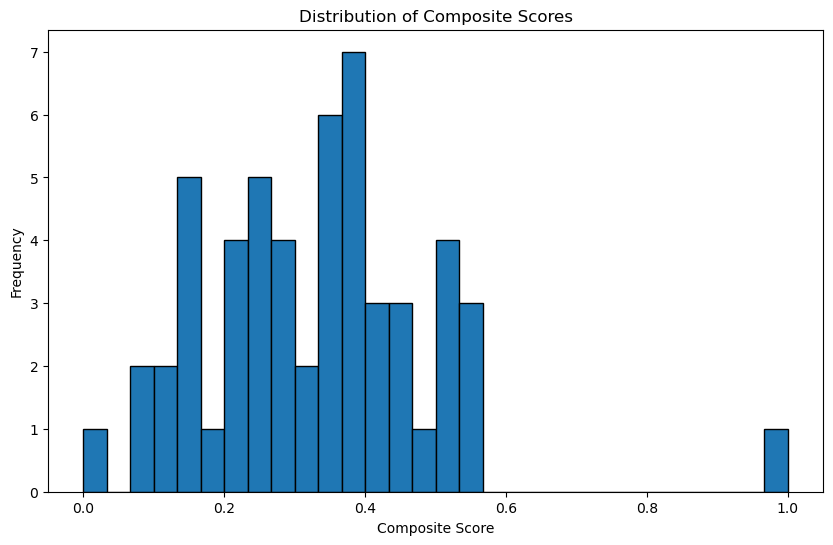

In [235]:
# Plot histogram of composite scores
plt.figure(figsize=(10, 6))
plt.hist(depot_metrics['composite_score'], bins=30, edgecolor='black')
plt.title('Distribution of Composite Scores')
plt.xlabel('Composite Score')
plt.ylabel('Frequency')
plt.show()

# Random Forest model to predict on_time deliveries using the composite score

### Classification: Using the discrete ABNORMAL column as target variable

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [154]:
X = depot_metrics[['composite_score']]
y = depot_metrics[['ABNORMAL']]

In [156]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [158]:
# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Regression: Using the continuous on_time_rate column as target variable

In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [208]:
X = depot_metrics[['tuned_composite_score']]
y = depot_metrics[['on_time_rate']]

In [199]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [229]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Absolute Error (MAE):", mae)
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 28.466984841854195
Root Mean Squared Error (RMSE): 5.34
Mean Absolute Error (MAE): 4.314510299654355
R-squared (R²): -1.08


This means, on average, our model’s predictions are off by about 5.34 units from the actual values.
An MAE of 4.31 means that, on average, our model's predictions deviate from the actual values by 4.31 units. 
##### Unlike RMSE, MAE is not sensitive to outliers and is more robust in that regard.
An R-squared value of -1.08 indicates that your model is performing worse than a simple mean-based model (i.e., a model that just predicts the mean of the target variable). Negative R-squared values suggest that the model is not capturing the relationship between features and the target variable effectively and might be overfitting or underfitting.

In [220]:
# Predict for the entire dataset
depot_metrics['y_pred'] = model.predict(X)

In [222]:
print(depot_metrics)

    DESTINATION_DEPOT_ID  total_inbounds  total_weight  average_weight  \
0                    100           22132     130276.61        5.886346   
1                    110           13950      90925.23        6.517938   
2                    120           16113     111833.48        6.940575   
3                    130           15751     112997.16        7.173967   
4                    140            8126      65756.45        8.092106   
5                    150           12633      88400.94        6.997621   
6                    160            9918      66630.69        6.718158   
7                    170           18396     124106.56        6.746388   
8                    180           11195      75159.79        6.713693   
9                    190            8630      59883.83        6.939030   
10                   200           20728     128980.18        6.222510   
11                   210            3543      24373.63        6.879376   
12                   220            76

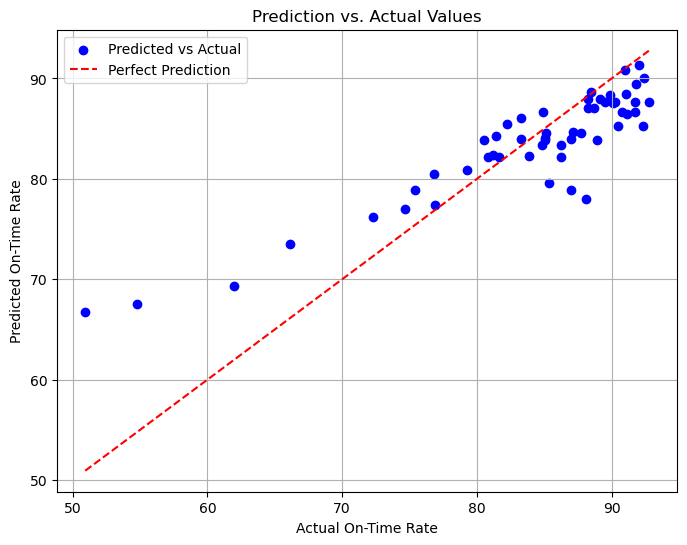

In [224]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(depot_metrics['on_time_rate'], depot_metrics['y_pred'], color='blue', label='Predicted vs Actual')

# Add a diagonal line for reference
plt.plot([depot_metrics['on_time_rate'].min(), depot_metrics['on_time_rate'].max()],
         [depot_metrics['on_time_rate'].min(), depot_metrics['on_time_rate'].max()],
         color='red', linestyle='--', label='Perfect Prediction')

# Add titles and labels
plt.title('Prediction vs. Actual Values')
plt.xlabel('Actual On-Time Rate')
plt.ylabel('Predicted On-Time Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

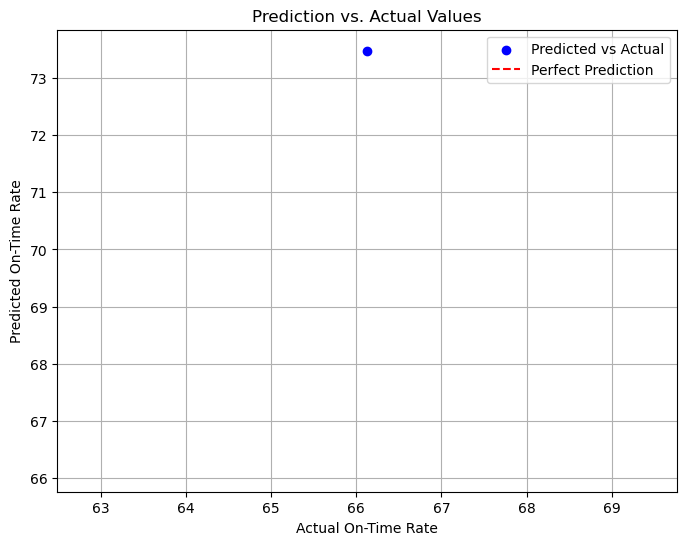

In [237]:
#Depot 120 
depot120_filtered = depot_metrics[depot_metrics['DESTINATION_DEPOT_ID'] == 120]

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(depot120_filtered['on_time_rate'], depot120_filtered['y_pred'], color='blue', label='Predicted vs Actual')

# Add a diagonal line for reference
plt.plot([depot120_filtered['on_time_rate'].min(), depot120_filtered['on_time_rate'].max()],
         [depot120_filtered['on_time_rate'].min(), depot120_filtered['on_time_rate'].max()],
         color='red', linestyle='--', label='Perfect Prediction')

# Add titles and labels
plt.title('Prediction vs. Actual Values')
plt.xlabel('Actual On-Time Rate')
plt.ylabel('Predicted On-Time Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Not enough data to say anything about depot 120.

# Peak Day/Hour Load: The number of parcels processed during peak hours

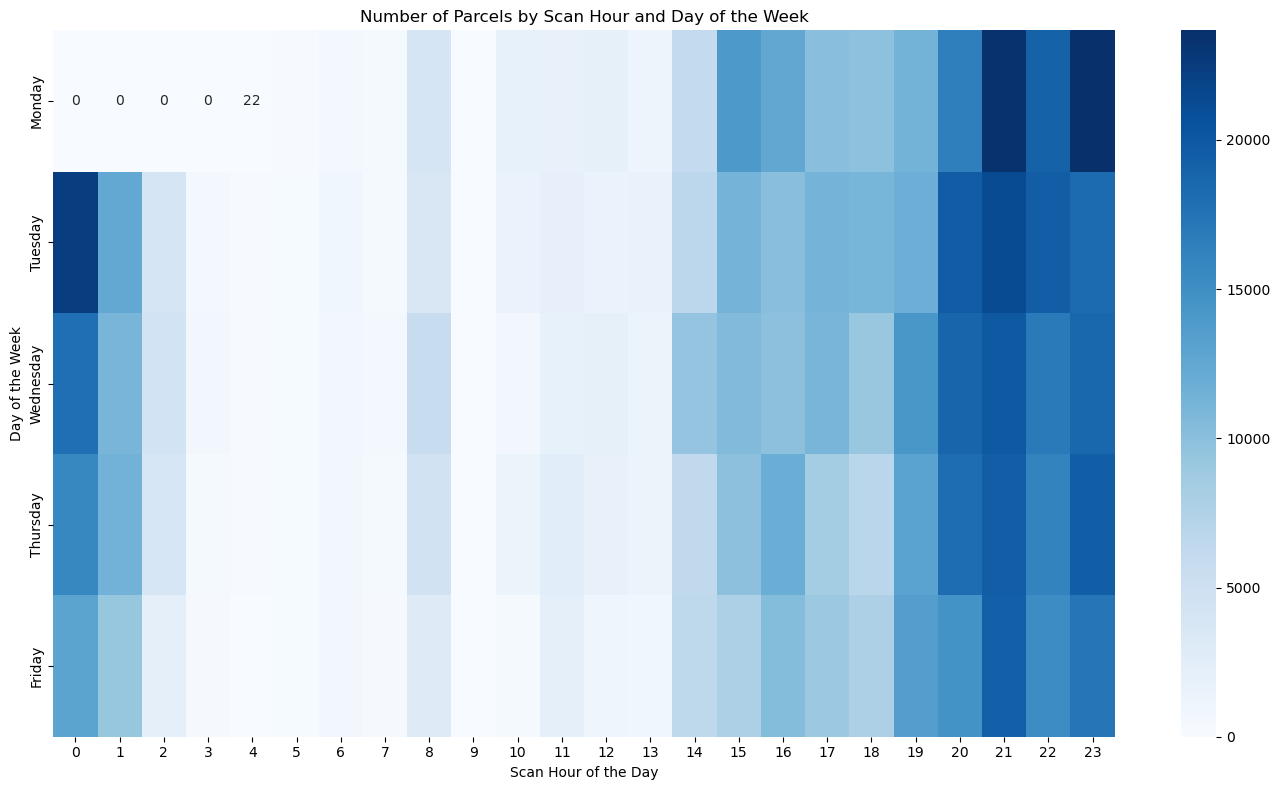

In [26]:
# Convert 'SCAN_DAY_OF_WEEK' from integer to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
inbound_df_filtered['SCAN_DAY_NAME'] = inbound_df_filtered['SCAN_DAY_OF_WEEK'].map(lambda x: day_names[x])

# Exclude Saturday and Sunday
inbound_df_filtered = inbound_df_filtered[~inbound_df_filtered['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
inbound_df_filtered['SCAN_DAY_NAME'] = inbound_df_filtered['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and count the number of parcels
parcel_counts = inbound_df_filtered.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size().reset_index(name='Parcel_Count')

# Pivot the data for heatmap
heatmap_data_parcel_counts = parcel_counts.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Parcel_Count')

# Ensure correct ordering of columns and index
heatmap_data_parcel_counts = heatmap_data_parcel_counts.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting the number of parcels for Depot 120
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data_parcel_counts, annot=True, fmt=".0f", cmap='Blues', cbar=True)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Number of Parcels by Scan Hour and Day of the Week')

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
# Print the 10 largest values of Parcel_Count
top_10_parcel_counts = parcel_counts.nlargest(10, 'Parcel_Count')
print(top_10_parcel_counts)

     SCAN_HOUR SCAN_DAY_NAME  Parcel_Count
115         23        Monday         23675
105         21        Monday         23445
1            0       Tuesday         22387
106         21       Tuesday         21186
107         21     Wednesday         19900
101         20       Tuesday         19684
111         22       Tuesday         19562
108         21      Thursday         19521
118         23      Thursday         19495
109         21        Friday         19301


## For depot 120

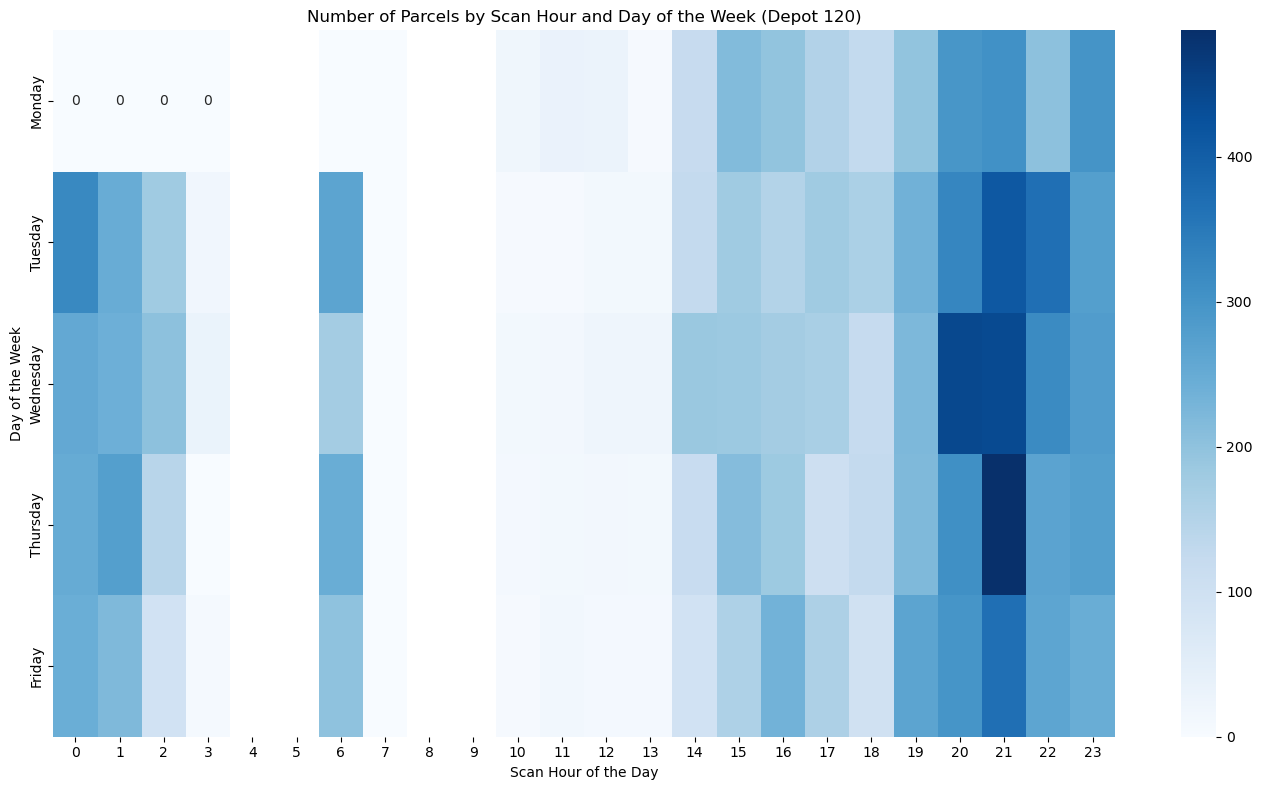

In [28]:
# Convert 'SCAN_DAY_OF_WEEK' from integer to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
inbound_df_filtered['SCAN_DAY_NAME'] = inbound_df_filtered['SCAN_DAY_OF_WEEK'].map(lambda x: day_names[x])

# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = inbound_df_filtered[inbound_df_filtered['DESTINATION_DEPOT_ID'] == 120]

# Exclude Saturday and Sunday
data_depot_120 = data_depot_120[~data_depot_120['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120['SCAN_DAY_NAME'] = data_depot_120['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and count the number of parcels
parcel_counts_120 = data_depot_120.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size().reset_index(name='Parcel_Count')

# Pivot the data for heatmap
heatmap_data_parcel_counts = parcel_counts_120.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Parcel_Count')

# Ensure correct ordering of columns and index
heatmap_data_parcel_counts = heatmap_data_parcel_counts.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting the number of parcels for Depot 120
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data_parcel_counts, annot=True, fmt=".0f", cmap='Blues', cbar=True)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Number of Parcels by Scan Hour and Day of the Week (Depot 120)')

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
# Print the 10 largest values of Parcel_Count
top_10_parcel_counts_120 = parcel_counts_120.nlargest(10, 'Parcel_Count')
print(top_10_parcel_counts_120)

    SCAN_HOUR SCAN_DAY_NAME  Parcel_Count
88         21      Thursday           487
82         20     Wednesday           443
87         21     Wednesday           439
86         21       Tuesday           412
89         21        Friday           369
91         22       Tuesday           369
81         20       Tuesday           327
1           0       Tuesday           320
92         22     Wednesday           317
83         20      Thursday           307


# Processing Time Analysis per parcel: between first scan and delivered event

For each UNITNO, check the difference between SCAN_DATETIME when EVENT_CODE is 3 (delivered) and when EVENT_CODE is 0 (data creation)
Use the dataframe df_unique

In [50]:
# Filter the DataFrame for EVENT_CODE 3 (delivered) and 0 (data creation)
delivered_df = df_unique[df_unique['EVENT_CODE'] == 3][['UNITNO', 'SCAN_DATETIME']]
created_df = df_unique[df_unique['EVENT_CODE'] == 0][['UNITNO', 'SCAN_DATETIME']]

# Rename columns to avoid confusion during merge
delivered_df.rename(columns={'SCAN_DATETIME': 'DELIVERED_DATETIME'}, inplace=True)
created_df.rename(columns={'SCAN_DATETIME': 'CREATED_DATETIME'}, inplace=True)

# Merge the DataFrames on UNITNO
merged_df = pd.merge(delivered_df, created_df, on='UNITNO')

# Calculate the difference between DELIVERED_DATETIME and CREATED_DATETIME
merged_df['TIME_DIFFERENCE'] = merged_df['DELIVERED_DATETIME'] - merged_df['CREATED_DATETIME']

# Print the DataFrame
print(merged_df[['UNITNO', 'CREATED_DATETIME', 'DELIVERED_DATETIME', 'TIME_DIFFERENCE']])

          UNITNO        CREATED_DATETIME  DELIVERED_DATETIME  \
0    10372017465 2024-07-18 15:32:32.914 2024-07-19 10:14:34   
1    10372047655 2024-07-18 16:36:31.349 2024-07-19 12:54:53   
2    10372047656 2024-07-18 16:30:28.411 2024-07-19 12:54:53   
3    10372047657 2024-07-18 16:36:07.711 2024-07-19 12:54:53   
4    10372047658 2024-07-18 16:32:01.528 2024-07-19 12:54:53   
..           ...                     ...                 ...   
930  89420012192 2024-07-18 18:33:33.267 2024-07-19 12:25:25   
931  89420012192 2024-07-18 18:33:33.268 2024-07-19 12:25:25   
932  89420012353 2024-07-19 17:13:30.928 2024-07-22 13:36:35   
933  89420012353 2024-07-19 17:13:30.929 2024-07-22 13:36:35   
934  89420012353 2024-07-19 17:13:30.929 2024-07-22 13:36:35   

           TIME_DIFFERENCE  
0   0 days 18:42:01.086000  
1   0 days 20:18:21.651000  
2   0 days 20:24:24.589000  
3   0 days 20:18:45.289000  
4   0 days 20:22:51.472000  
..                     ...  
930 0 days 17:51:51.733000  

# Processing Time per Depot 

In [56]:
# Merge with original DataFrame to get DESTINATION_DEPOT_ID
merged_df_with_depot = pd.merge(merged_df, df_unique[['UNITNO', 'DESTINATION_DEPOT_ID']], on='UNITNO')
# Group by DESTINATION_DEPOT_ID and calculate the mean processing time
processing_time_per_depot = merged_df_with_depot.groupby('DESTINATION_DEPOT_ID')['TIME_DIFFERENCE'].mean()

# Convert the result to a DataFrame for better readability
processing_time_per_depot_df = processing_time_per_depot.reset_index()

# Print the result
print(processing_time_per_depot_df)

    DESTINATION_DEPOT_ID           TIME_DIFFERENCE
0                    100 1 days 05:31:23.176199367
1                    110 2 days 11:06:16.652012820
2                    120 0 days 14:42:38.203923076
3                    130 1 days 06:50:03.653703389
4                    140 2 days 15:09:10.784301886
..                   ...                       ...
61                   850    1 days 08:05:05.415250
62                   860 1 days 09:13:40.872633333
63                   870 1 days 03:11:24.321758992
64                   880 1 days 14:34:39.231818181
65                   890 2 days 03:01:05.454859375

[66 rows x 2 columns]


AttributeError: 'numpy.int64' object has no attribute 'startswith'

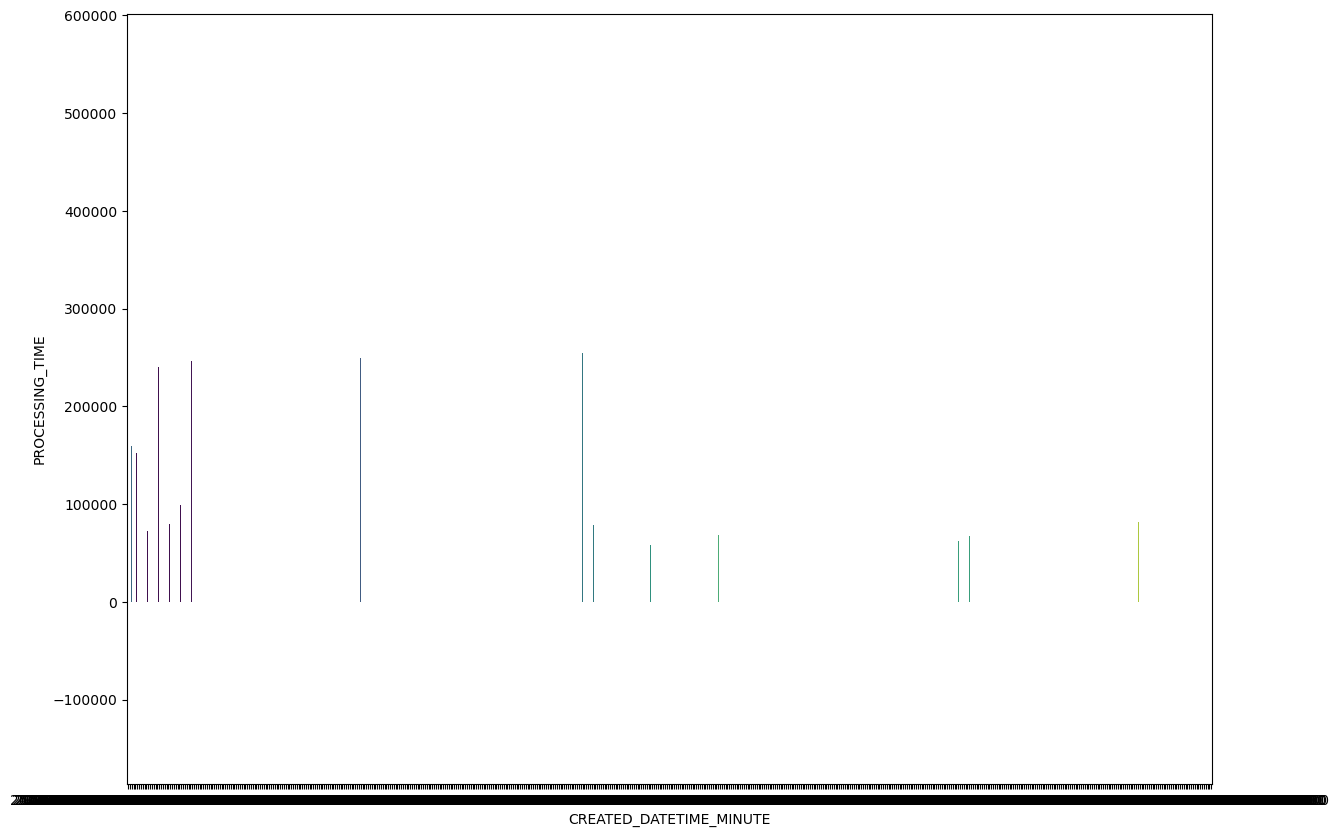

In [68]:
# Ensure SCAN_DATETIME is a datetime object
df_unique['SCAN_DATETIME'] = pd.to_datetime(df_unique['SCAN_DATETIME'])

# Filter the DataFrame for EVENT_CODE 3 (delivered) and 0 (data creation)
delivered_df = df_unique[df_unique['EVENT_CODE'] == 3][['UNITNO', 'SCAN_DATETIME', 'DESTINATION_DEPOT_ID']]
created_df = df_unique[df_unique['EVENT_CODE'] == 0][['UNITNO', 'SCAN_DATETIME']]

# Rename columns to avoid confusion during merge
delivered_df.rename(columns={'SCAN_DATETIME': 'DELIVERED_DATETIME'}, inplace=True)
created_df.rename(columns={'SCAN_DATETIME': 'CREATED_DATETIME'}, inplace=True)

# Merge the DataFrames on UNITNO
merged_df = pd.merge(delivered_df, created_df, on='UNITNO')

# Calculate the difference between DELIVERED_DATETIME and CREATED_DATETIME
merged_df['PROCESSING_TIME'] = merged_df['DELIVERED_DATETIME'] - merged_df['CREATED_DATETIME']

# Convert PROCESSING_TIME to a numeric value (e.g., seconds)
merged_df['PROCESSING_TIME'] = merged_df['PROCESSING_TIME'].dt.total_seconds()

# Round the CREATED_DATETIME to the nearest minute
merged_df['CREATED_DATETIME_MINUTE'] = merged_df['CREATED_DATETIME'].dt.to_period('T').astype('datetime64')

# Group by DESTINATION_DEPOT_ID and CREATED_DATETIME_MINUTE and calculate the average processing time
average_processing_time_per_minute = merged_df.groupby(['DESTINATION_DEPOT_ID', 'CREATED_DATETIME_MINUTE'])['PROCESSING_TIME'].mean().reset_index()

# Plotting the result
plt.figure(figsize=(14, 10))

# Create a bar plot with DESTINATION_DEPOT_ID and CREATED_DATETIME_MINUTE
sns.barplot(data=average_processing_time_per_minute, x='CREATED_DATETIME_MINUTE', y='PROCESSING_TIME', hue='DESTINATION_DEPOT_ID', palette='viridis')

# Customize the plot
plt.xlabel('Minute')
plt.ylabel('Average Processing Time (seconds)')
plt.title('Average Processing Time per Minute by Destination Depot')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Destination Depot ID')
plt.tight_layout()

# Show the plot
plt.show()

# Processing Time for Depot 120, PRIOR DEPOT GROUPING

only look at data with DESTINATION_DEPOT_ID 120 and check processing_time per SCAN_DEPOT_ID

# Special Handling Requirements (Small and Hazardous criteria)

- Check mean/median composite score per small and per hazardous 
- Check the distribution of composite score for small=1 and then for small=0 (same for hazardous)
##### Here we are using inbound_df_filtered dataframe

# Efficiency Ratios: For each depot parcels per hour, weight per hour, and volume per hour

- Average weight by Scan Hour and Day of the Week (all depots and then Depot 120)
- Average Volume by Scan Hour and Day of the Week (all depots and then Depot 120)

## Do we have any parcels that were not delivered? EVENT_CODE 4